</style>
<h1  style="text-align:center;font-size:60px"> Projet SR2I208 
    <h2 style="text-align:center">Détection de virus par analyse des codes binaires</h2>
    <br><br>
    <h2 style="text-align:left;font-size:20px">
        <u> Date:</u> Juin 2021 <br><br>
        <u> Author of this document:</u><br><br>
          <li>Maha Meihemid ( meihemid.meihemid@telecom-paris.fr )</li><br>
     </h2>
</h1>

In [1]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
print("les bibliothèques sont importées")

les bibliothèques sont importées


## I.Etude de données 

L'ensemble des données que nous avons utilisé est principalement du dataset : jeu de données Malimg.

L' ensemble de données Malimg contient 9339 images de logiciels malveillants, appartenant à 25 familles/classes. Ainsi, notre objectif est d'effectuer une classification multi-classes des logiciels malveillants.
C’est à dire  que nos modèles à partir d’une entrée malware va nous dire de quelle type de malware appartient.


In [2]:
path_root="data"

In [3]:
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


Nous pouvons voir que nos 25 classes ont été bien reconnues (grâce à nos sous-dossiers). Précisons cela à l'aide du dictionnaire.

In [4]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

**batches**  générés avec ImageDataGenerator() sont des itérateurs. Par conséquent, nous utilisons next() pour parcourir tous ses éléments et générer un lot d'images et d'étiquettes à partir de l'ensemble de données.

In [5]:
imgs, labels = next(batches)

In [6]:
imgs[1].shape

(64, 64, 3)

Comme vous pouvez le voir, nos images sont en RGB avec une forme 64x64 [largeur x longueur x profondeur].

In [7]:
imgs.shape

(9339, 64, 64, 3)

**labels** a la taille  (batch_size, number of classes).

In [8]:
labels.shape

(9339, 25)

The following method allows us La méthode suivante nous permet de tracer un échantillon d'images dans notre jeu de données.

In [9]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

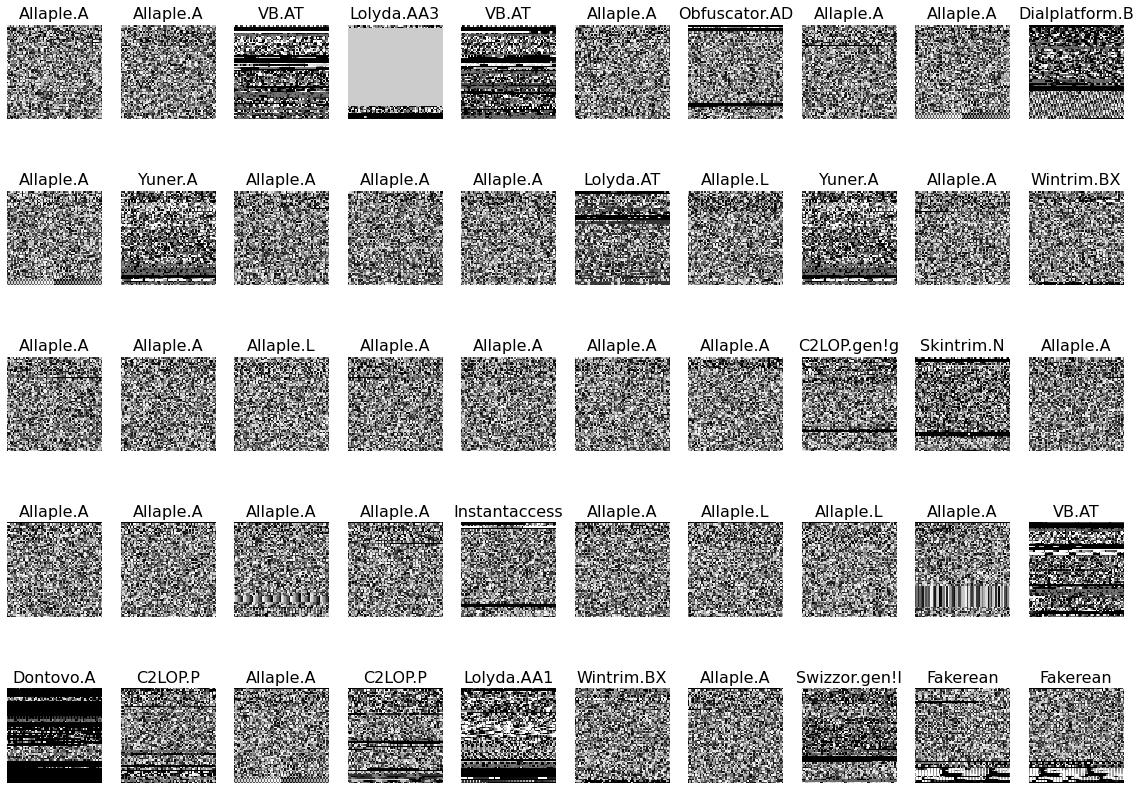

In [10]:
plots(imgs, titles = labels)

Nous pouvons déjà observer des différences entre les classes.

Toutes nos images sont enfin prêtes à être utilisées. Vérifions la répartition des données entre les classes :

In [9]:
classes = batches.class_indices.keys()

In [10]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

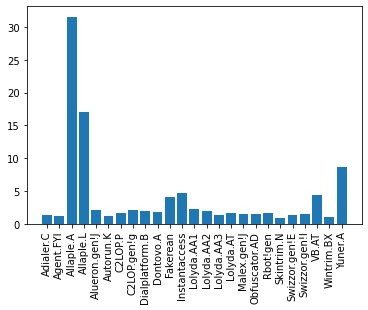

In [11]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

Comme vous pouvez le remarquer, notre jeu de données est assez déséquilibré : plus de 30% des images appartiennent à la classe 2 : Allaple.A et 17% à la classe 3 : Allaple.L !


#### Train and test

Divisons notre modèle en deux parties : train et test, selon un ratio 70% train - 30% test.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [15]:
X_train_flattened = np.array([X_train_i.ravel() for X_train_i in X_train])
X_test_flattened = np.array([X_test_i.ravel() for X_test_i in X_test])


## II.Models de Machine learning

##### Multi-layer Perceptron classifier

In [16]:
##############Neural network model##########################
############################################################

input_shape = X_train_flattened[0].shape

model = Sequential()
model.add(Dense(1000, input_shape= input_shape, activation='sigmoid')) #1000 neurone in the first hiden layer 

model.add(Dense(1000, activation='sigmoid'))  
# model.add(Dropout(0.3))

model.add(Dense(1000, activation='sigmoid'))  

model.add(Dense(1000, activation='sigmoid'))  

model.add(Dense(25, activation='softmax')) 

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy']) #Learning the parameters

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              12289000  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_4 (Dense)              (None, 25)                25025     
Total params: 15,317,025
Trainable params: 15,317,025
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X_train_flattened, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test_flattened,y_test))

Epoch 1/10
205/205 [==============================] - 44s 198ms/step - loss: 0.1668 - accuracy: 0.2865 - val_loss: 0.1414 - val_accuracy: 0.2994
Epoch 2/10
205/205 [==============================] - 30s 145ms/step - loss: 0.1387 - accuracy: 0.3052 - val_loss: 0.1427 - val_accuracy: 0.2994
Epoch 3/10
205/205 [==============================] - 29s 142ms/step - loss: 0.1375 - accuracy: 0.3258 - val_loss: 0.1278 - val_accuracy: 0.3837
Epoch 4/10
205/205 [==============================] - 30s 145ms/step - loss: 0.1100 - accuracy: 0.4287 - val_loss: 0.1031 - val_accuracy: 0.4251
Epoch 5/10
205/205 [==============================] - 29s 143ms/step - loss: 0.0976 - accuracy: 0.4624 - val_loss: 0.0984 - val_accuracy: 0.4425
Epoch 6/10
205/205 [==============================] - 31s 149ms/step - loss: 0.0925 - accuracy: 0.4702 - val_loss: 0.0919 - val_accuracy: 0.4600
Epoch 7/10
205/205 [==============================] - 32s 156ms/step - loss: 0.0907 - accuracy: 0.4695 - val_loss: 0.0886 - val_ac

In [18]:
y_train_new = np.where(y_train==1)[1]
y_test_new = np.where(y_test==1)[1]

##### Decision Trees

In [19]:
DT = DecisionTreeClassifier()
DT.fit(X_train_flattened, y_train_new)

DecisionTreeClassifier()

In [20]:
print("Le Score du DT : ",f1_score(y_test_new, DT.predict(X_test_flattened), average='macro'))

Le Score du DT :  0.8412533992051471


##### Random forest

In [21]:
RFC = RandomForestClassifier()
RFC.fit(X_train_flattened, y_train_new)

RandomForestClassifier()

In [41]:
print("Le Score du RFC : ",f1_score(y_test_new, RFC.predict(X_test_flattened), average='macro'))

Le Score du RFC :  0.8995430597479737


In [22]:
# Confusion matrix pour Random Forest
y_pred = RFC.predict(X_test_flattened)
confusion_matrix(y_test_new, y_pred)

array([[ 32,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  34,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 839,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 492,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  72,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  31,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  28,   0,   0,   0,  11,  15,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0],
      

In [26]:
# GridSearchCV for RandomForestClassifier
print("GridSearchCV for RandomForestClassifier")
# Create param grid.
param_grid = {
    'n_estimators' : list(range(1,5)), 
    'class_weight': ['balanced'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':['gini', 'entropy']
    }
scv = StratifiedKFold(n_splits=5)
rfc_grid = GridSearchCV(RFC,param_grid = param_grid, cv = scv, verbose=True, n_jobs=-1)
best_rfc_grid = rfc_grid.fit(X_train_flattened, y_train_new)
best_rfc_grid

GridSearchCV for RandomForestClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 2, 3, 4]},
             verbose=True)

In [28]:
print("Best model:\n", best_rfc_grid.best_params_)

Best model:
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 4}


In [34]:
RFC = RandomForestClassifier(random_state=0,class_weight='balanced',
                             criterion= 'entropy',max_depth= 9,max_features='auto',n_estimators= 96)
RFC.fit(X_train_flattened, y_train_new)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, n_estimators=96, random_state=0)

In [35]:
print("Le Score du RFC : ",f1_score(y_test_new, RFC.predict(X_test_flattened), average='macro'))

Le Score du RFC :  0.9137373987126438


#### Logistic regression

In [40]:
LGR = LogisticRegression()
LGR.fit(X_train_flattened, y_train_new)

D:\anconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [43]:
print("Le Score du LGR : ",f1_score(y_test_new, LGR.predict(X_test_flattened), average='macro'))

Le Score du LGR :  0.8830932327519986


#### KNeighborsClassifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier 
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_flattened, y_train_new)

KNeighborsClassifier(n_neighbors=3)

In [37]:
print("Le Score du neigh : ",f1_score(y_test_new, neigh.predict(X_test_flattened), average='macro'))

Le Score du neigh :  0.5975892065929994


In [39]:
# GridSearchCV for KNeighborsClassifier
k_range = list(range(1,20))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)
#print (param_grid)
grid = GridSearchCV(neigh, param_grid, cv = scv, scoring = 'accuracy')
grid.fit(X_train_flattened, y_train_new)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [40]:
print("Best model:\n", grid.best_params_)

Best model:
 {'n_neighbors': 19, 'weights': 'distance'}


In [41]:
print("Le Score du neigh : ",f1_score(y_test_new, grid.predict(X_test_flattened), average='macro'))

Le Score du neigh :  0.7226715401668636


#### Convolution nural network

In [23]:
num_classes=25
def CNN_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [24]:
CNN =CNN_model()
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 30)        840       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 15)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 15)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2940)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [25]:
CNN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
205/205 [==============================] - 28s 132ms/step - loss: 2.2675 - accuracy: 0.3709 - val_loss: 1.0360 - val_accuracy: 0.6420
Epoch 2/10
205/205 [==============================] - 21s 102ms/step - loss: 0.9712 - accuracy: 0.6643 - val_loss: 0.5163 - val_accuracy: 0.8776
Epoch 3/10
205/205 [==============================] - 20s 100ms/step - loss: 0.5761 - accuracy: 0.8167 - val_loss: 0.3170 - val_accuracy: 0.9061
Epoch 4/10
205/205 [==============================] - 21s 105ms/step - loss: 0.3904 - accuracy: 0.8901 - val_loss: 0.2383 - val_accuracy: 0.9211
Epoch 5/10
205/205 [==============================] - 21s 102ms/step - loss: 0.3165 - accuracy: 0.9045 - val_loss: 0.2009 - val_accuracy: 0.9375
Epoch 6/10
205/205 [==============================] - 24s 116ms/step - loss: 0.2794 - accuracy: 0.9112 - val_loss: 0.2095 - val_accuracy: 0.9340
Epoch 7/10
205/205 [==============================] - 19s 94ms/step - loss: 0.2406 - accuracy: 0.9243 - val_loss: 0.1649 - val_acc